# The SIMPLE model

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np
import bayesflow as bf
import keras

### Simulator

In [2]:
max_n_words=40
def context(version=None, max_n_words=max_n_words):
    if version is None:
        version = np.random.randint(0, 2)
    return dict(
        n_obs = np.random.randint(1200, 1521),
        n_words = np.random.randint(10, max_n_words+1),
        offset = np.random.randint(10, 26),
        lag = np.random.randint(1, 3),
        version = version
    )

In [3]:
def prior():
    return dict(
        c = np.random.gamma(shape=5, scale=2.5),
        s = np.random.gamma(shape=5, scale=2.5),
        t = np.random.beta(a=5, b=3)
    )

In [4]:
def calculate_log_T(offset, lag, n_words):
    x = np.arange(n_words, 0, -1) - 1
    return np.log(offset + lag * x)

def prob_correct(c, s, t, n_words, offset, lag, version):
    log_T = calculate_log_T(offset, lag, n_words)

    eta = np.zeros((n_words, n_words))
    d = np.zeros((n_words, n_words))

    for i in range(n_words):
        for j in range(n_words):
            abs_diff = np.abs(log_T[i] - log_T[j])
            eta[i, j] = np.exp(-c * abs_diff)
        d[i,:] = eta[i,:] / np.sum(eta[i,:])
    
    r = 1 / (1 + np.exp(-s * (d - t)))

    theta = np.ones(max_n_words)

    for i in range(n_words):
        if version < 0.5:
            theta[i] = np.min([1, np.sum(r[i,:])])
        else:
            theta[i] = 1 - np.prod(1-r[i,:])

    return theta

def likelihood(c, s, t, n_obs, n_words, offset, lag, version, max_n_words=max_n_words):
    theta = prob_correct(c, s, t, n_words, offset, lag, version)

    y = np.zeros(max_n_words)
    observed = np.zeros(max_n_words)
    trial = np.arange(max_n_words)

    y[range(n_words)] = np.random.binomial(n=n_obs, p=theta[range(n_words)], size=n_words)
    observed[range(n_words)] = 1

    return dict(y=y, observed=observed, trial=trial)


In [5]:
simulator=bf.make_simulator([context, prior, likelihood])

In [6]:
df=simulator.sample(100)

for key, value in df.items():
    print(key, "shape: ", value.shape)

n_obs shape:  (100, 1)
n_words shape:  (100, 1)
offset shape:  (100, 1)
lag shape:  (100, 1)
version shape:  (100, 1)
c shape:  (100, 1)
s shape:  (100, 1)
t shape:  (100, 1)
y shape:  (100, 40)
observed shape:  (100, 40)
trial shape:  (100, 40)

### Approximator

We will use the observed successfull trials as variables that will be
passed into a time series summary network, as well as the number of
observations, number of words, offset, lag, and version of the model
directly into the inference network. The inference network will learn to
predict the posterior distribution of parameters $c$, $s$, and $t$.
Using the adapter, we will also make sure that we respect the natural
constraints of the parameters.

In [7]:
adapter = (bf.Adapter()
    .constrain(["c", "s"], lower=0)
    .constrain("t", lower=0, upper=1)
    .standardize(include=["c", "s", "t"])
    .as_set(["y", "observed", "trial"])
    .concatenate(["y", "observed", "trial"], into="summary_variables")
    .concatenate(["n_obs", "n_words", "offset", "lag", "version"], into="inference_conditions")
    .concatenate(["c", "s", "t"], into="inference_variables")
)

In [8]:
df=adapter(simulator.sample(100), stage="inference")

for key, value in df.items():
    print(key, "shape: ", value.shape)

summary_variables shape:  (100, 40, 3)
inference_conditions shape:  (100, 5)
inference_variables shape:  (100, 3)

In [ ]:
workflow=bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow(),
    summary_network=bf.networks.DeepSet(),
    initial_learning_rate=1e-3
)

### Training

Since the simulation is relatively involved, we will presimulate data
and fit the networks in an offline regime to speed up training.

In [10]:
train_data = simulator.sample(20_000)

In [11]:
val_data = simulator.sample(5_000)

In [ ]:
history=workflow.fit_offline(
    data=train_data, 
    validation_data=val_data,
    epochs=200,
    batch_size=500)

### Validation

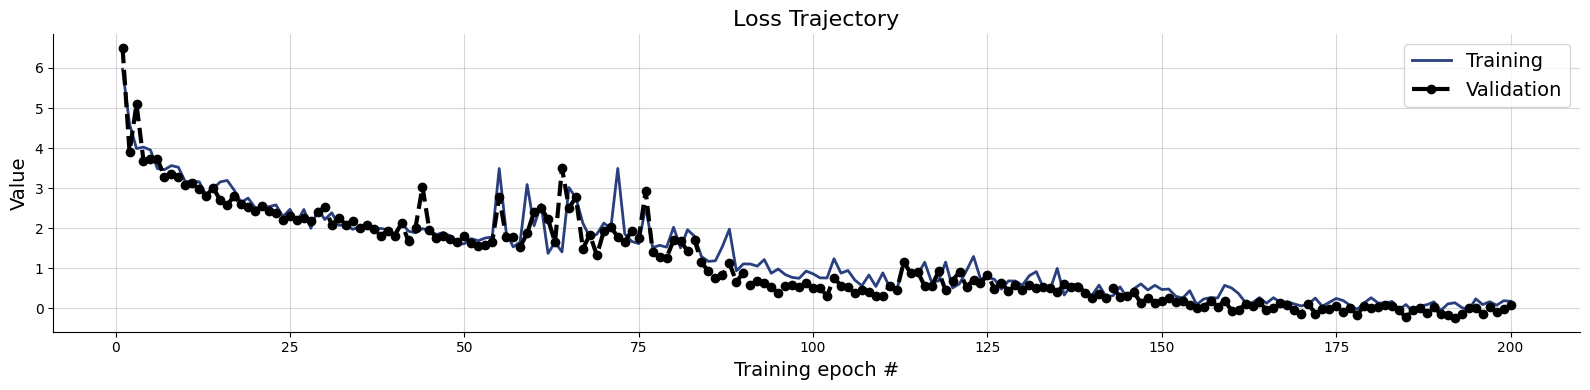

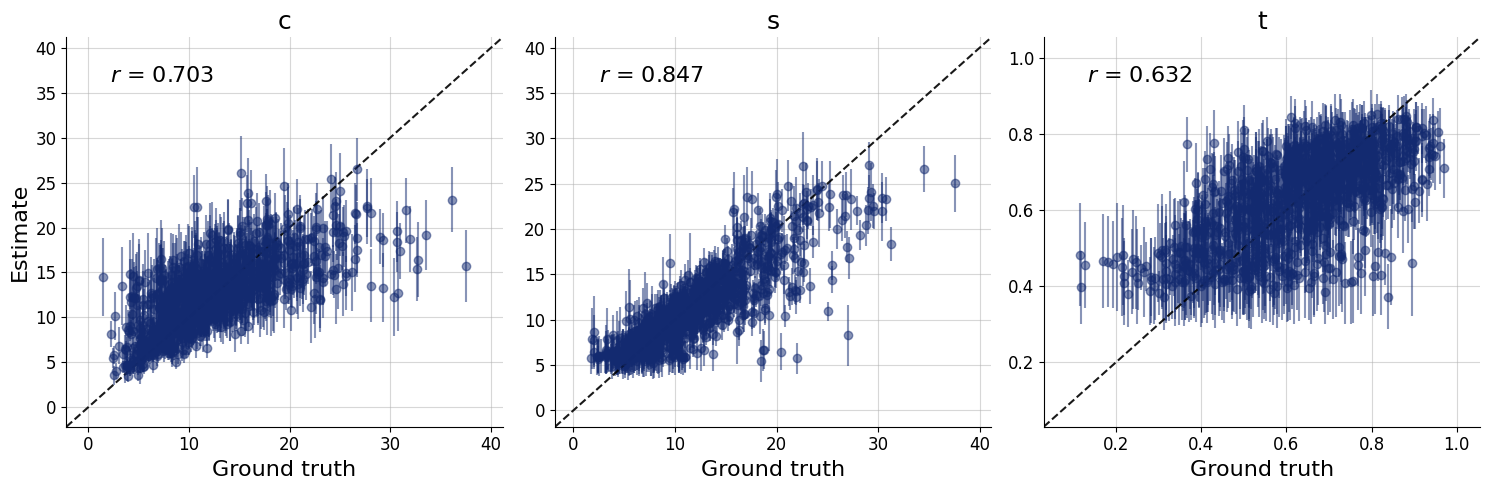

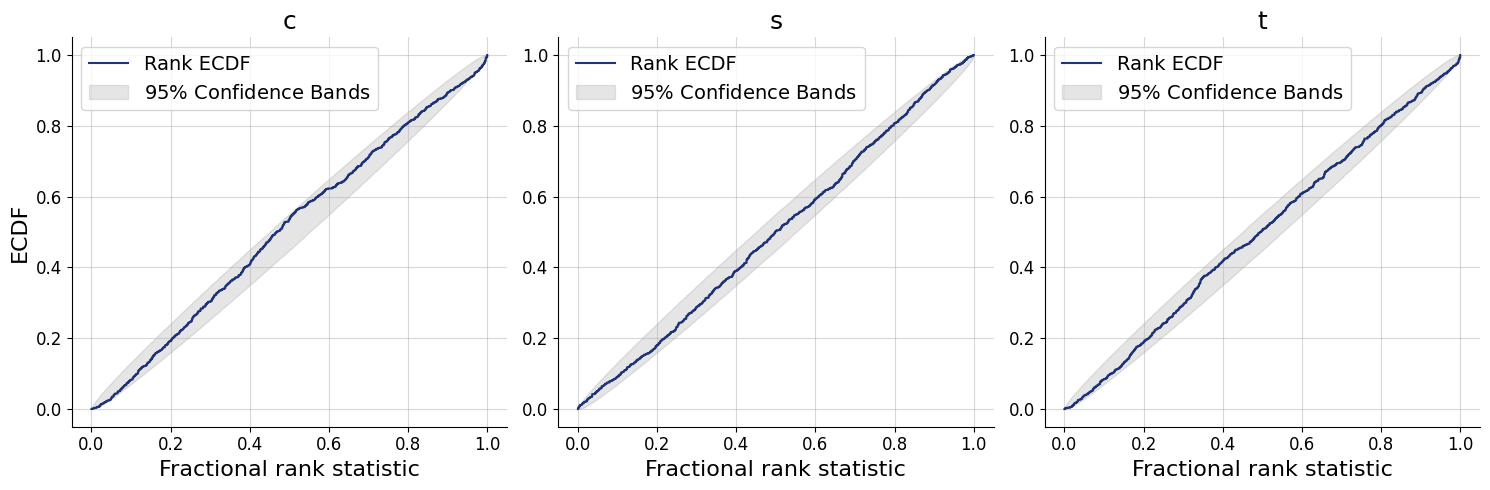

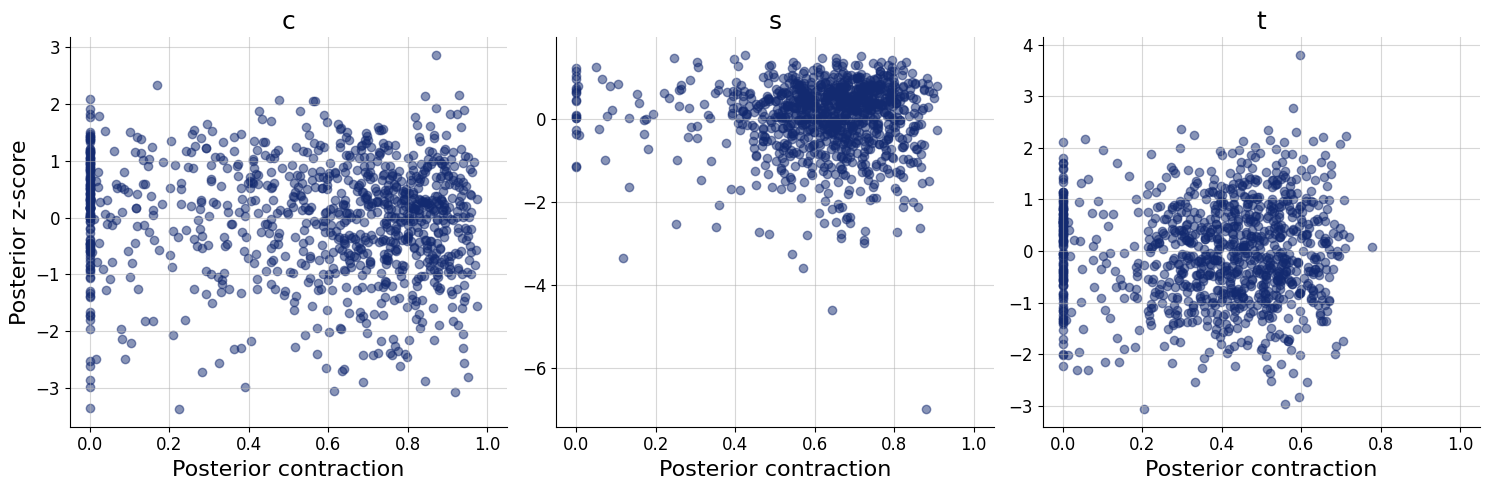

In [13]:
test_data = simulator.sample(1000, version=0)
figs=workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

In [14]:
y = np.array([
    [994,806,691,634,634,835,965,1008,1181,1382,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [794,640,576,512,486,486,512,512,538,640,742,794,1024,1126,1254,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [836,623,562,517,441,471,441,395,350,441,456,486,456,593,608,684,897,1110,1353,1459,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [699,410,304,243,258,243,228,213,304,350,395,319,365,410,456,608,958,1170,1277,1474,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
    [576,360,240,228,240,240,228,216,240,240,240,240,228,240,216,204,240,228,240,240,264,252,288,324,444,480,660,912,1080,1188,0,0,0,0,0,0,0,0,0,0],
    [384,256,154,154,141,128,154,154,154,128,179,141,128,141,154,179,154,141,179,128,154,128,154,192,179,166,154,218,218,218,256,256,230,307,384,512,691,922,1114,1254]
])[...,np.newaxis]

observed = np.zeros_like(y)
observed[np.where(y != 0)] = 1

trial = np.arange(max_n_words)[np.newaxis]
trial = np.tile(trial, [6, 1])
trial.shape

(6, 40)

In [15]:
inference_data = dict(
    y = y,
    observed = observed,
    trial = trial,
    n_obs = np.array([1440, 1280, 1520, 1520, 1200, 1280])[...,np.newaxis],
    n_words = np.array([10, 15, 20, 20, 30, 40])[...,np.newaxis],
    offset = np.array([15, 20, 25, 10, 15, 20])[...,np.newaxis],
    lag = np.array([2, 2, 2, 1, 1, 1])[...,np.newaxis],
    version = np.zeros(6)[...,np.newaxis]
)

In [16]:
posterior_samples = workflow.sample(num_samples=2000, conditions=inference_data)

In [17]:
def plot_data(c, s, t, data, max_n_words=max_n_words):
    n_datasets, n_samples, _ = c.shape
    y_pred = np.zeros((n_datasets, n_samples, max_n_words))
    for d in range(n_datasets):
        for i in range(n_samples):
            n_obs = int(data['n_obs'][d, 0])
            n_words = int(data['n_words'][d, 0])
            offset = int(data['offset'][d, 0])
            lag = int(data['lag'][d, 0])
            version = int(data['version'][d, 0])
            theta = prob_correct(c=c[d, i, 0], s=s[d, i, 0], t=t[d, i, 0], 
                                 n_words=n_words, offset=offset, 
                                 lag=lag, version=version)
            y_pred[d, i, range(n_words)] = np.random.binomial(n=n_obs, p=theta[range(n_words)], size=n_words)

    y = np.squeeze(data['y'])/data['n_obs']
    y_hat = np.mean(y_pred, axis=1)/data['n_obs']
    lower = np.quantile(y_pred, q = 0.025, axis=1)/data['n_obs']
    upper = np.quantile(y_pred, q = 0.975, axis=1)/data['n_obs']

    return y, y_hat, lower, upper

In [18]:
y, y_hat, lower, upper = plot_data(**posterior_samples, data=inference_data)

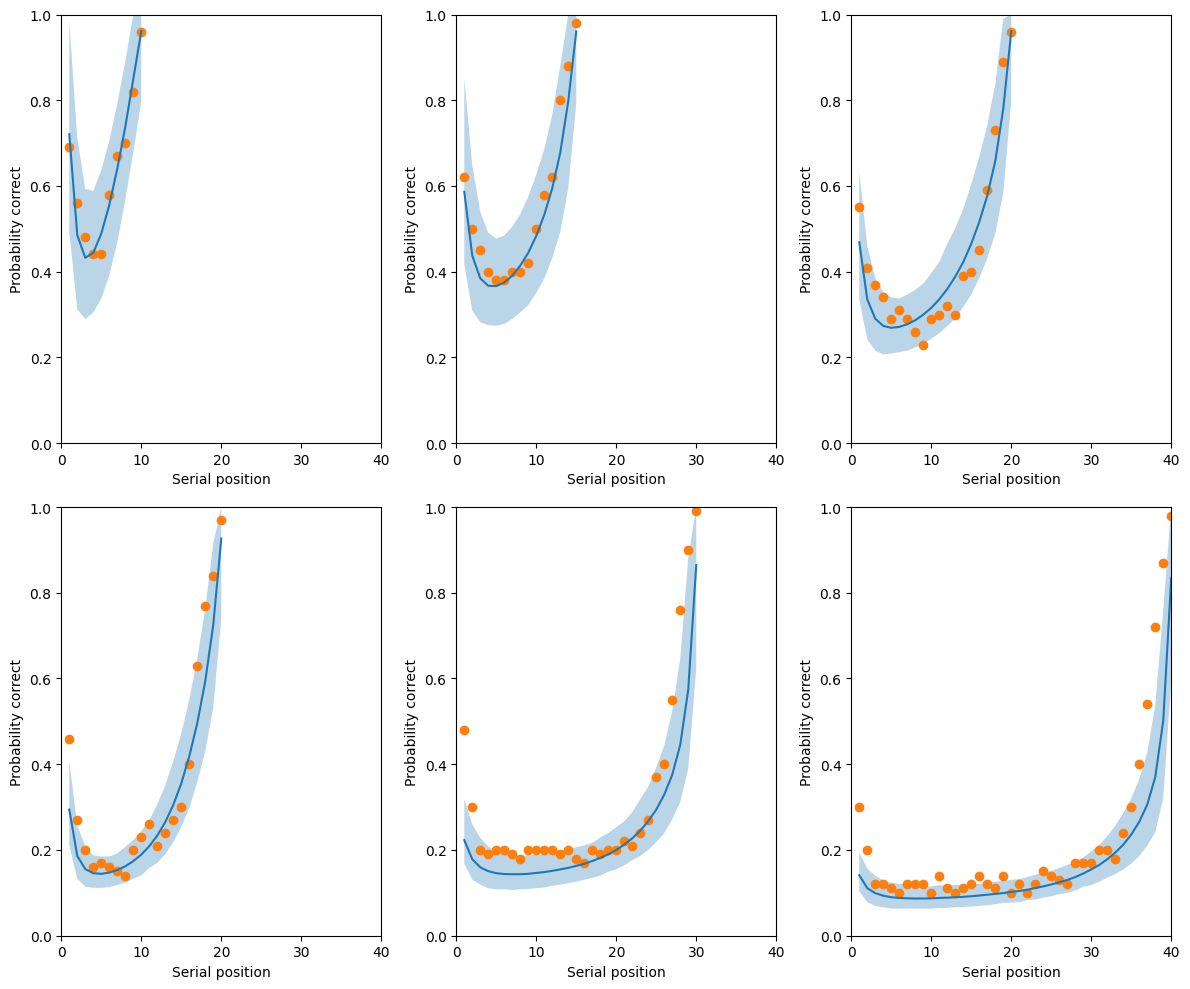

In [19]:
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

for d, ax in enumerate(axes):
    ax.set_ylim([0, 1])
    ax.set_xlim([0, max_n_words])
    ax.set_xlabel("Serial position")
    ax.set_ylabel("Probability correct")

    n_obs = int(inference_data['n_obs'][d, 0])
    n_words = int(inference_data['n_words'][d, 0])
    observed = range(n_words)
    x = range(1, n_words+1)

    ax.fill_between(x, lower[d, observed], upper[d, observed], alpha=0.3)
    ax.plot(x, y_hat[d, observed])
    ax.scatter(x, y[d, observed])

fig.tight_layout()